In [1]:
## initialization 1214

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

# Reinforcement Learning in Serial Dependence 2

最简单的 model-free RL 并没有办法成功捕捉到知觉上的序列依赖性，因为其本身也的确没有办法进行对于状态空间上的价值积累。<br><br> 所以在这一部分的模型中，我们尝试建立一个 model-based 的 RL 模型，来捕捉知觉上的序列依赖性。这个模型的基本思路是，我们在每一次的决策中，都会根据当前的状态，以及状态下动作空间的价值进表征行决策。而相应地也只会更新当前状态下的动作对应的价值。

## 1 Orientation Perception

This section is the same as model-free RL and employs a SDT model to simulate the process of orientation perception. 

We assume that, the perception is un-biased (criterion = 1/2), the noise is Gaussian and common for all orientations, and the SDT model is optimal (i.e. the SDT model is the same as the ideal observer).

The common standard deviation is:  0.7413011092528007
The average hit rate is:  0.749862
The average correct rejection rate is:  0.749332


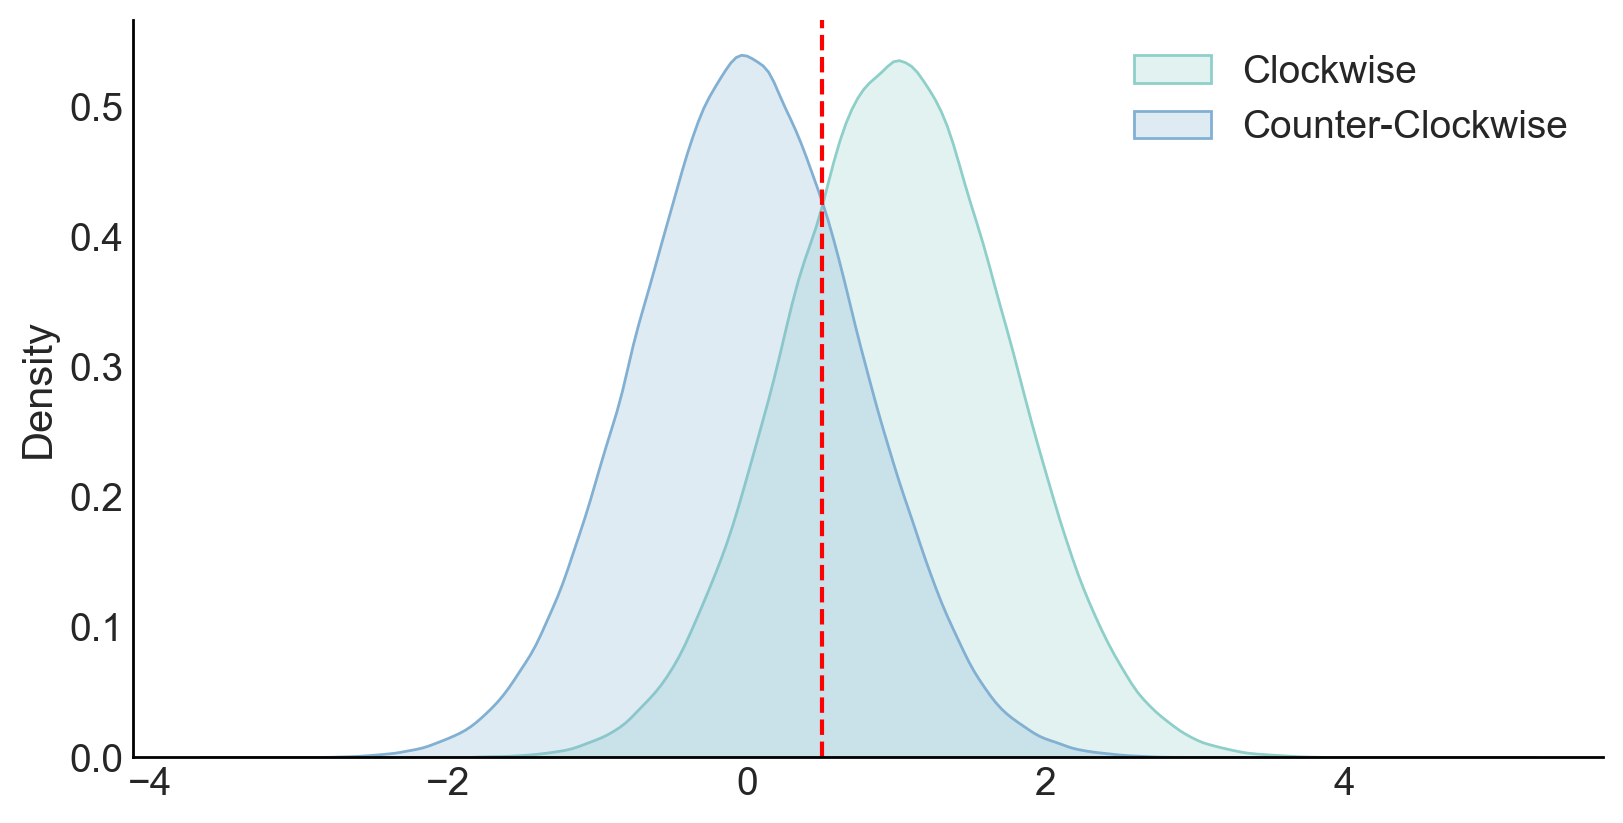

In [2]:
# @title Orientation Judgement under SDT
import numpy as np
import scipy.stats as stats
from scipy.optimize import fsolve

# We set the hit rate to 0.75 and assume Clockwise is the signal (1:CW, 0:CCW)
Goal_Hit_Prob = 0.75
signal_mean = 1 
noise_mean = 0
criterion = 0.5 # we assume the criterion is 0.5, since the two orientations are equally likely

# Calculate the most probable common standard deviation
def find_std(std):
    return stats.norm.cdf(criterion, signal_mean, std) - 0.25

# rep_times = 1000 # the number of times we repeat the optimization to find the best solution
# opt_std = []
# for irep in range(rep_times):
#     std_initial_guess = np.random.uniform(0.1, 1.0)
#     std_solution = fsolve(find_std, std_initial_guess)
#     opt_std.append(std_solution[0])
    
# common_std = np.mean(opt_std)
common_std = 0.7413011092528007
print('The common standard deviation is: ', common_std)

# Test if this parameter set can generate average hit rate of 0.75
# Generate a set of 10000 random samples from a normal distribution with mean = 1.0, std = common_std
sample_size = 1000000
samples_1 = np.random.normal(signal_mean, common_std, int(sample_size/2))
samples_2 = np.random.normal(noise_mean, common_std, int(sample_size/2))
samples = np.concatenate((samples_1, samples_2), axis=0)
                    
# Calculate the average hit rate and correct rejection rate
hit_rate = np.sum(samples_1 > criterion) / len(samples_1)
print('The average hit rate is: ', hit_rate)
cr_rate = np.sum(samples_2 < criterion) / len(samples_2)
print('The average correct rejection rate is: ', cr_rate)

# Visualize the distributions of the two orientations
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(samples_1, shade=True, color=gr, label='Clockwise')
sns.kdeplot(samples_2, shade=True, color=bl, label='Counter-Clockwise')
plt.axvline(x=criterion, color='r', linestyle='--')
plt.legend()
plt.show()

In [3]:
# The perception process is reduced to a SDT model
def Data_Gen(trialnum, 
             signal_mean = 1, noise_mean = 0, criterion = 0.5, std = 0.7413011092528007):
    '''
    Generate data with noise for a given number of trials.
    '''
    samples_1 = np.random.normal(signal_mean, std, int(trialnum/2))
    labels_1 = np.ones(int(trialnum/2))
    samples_2 = np.random.normal(noise_mean, std, int(trialnum/2))
    labels_2 = np.zeros(int(trialnum/2))
    samples = np.concatenate((samples_1, samples_2), axis=0)
    labels = np.concatenate((labels_1, labels_2), axis=0)
    # shuffle the data
    idx = np.arange(trialnum)
    np.random.shuffle(idx)
    samples = samples[idx]
    labels = labels[idx]
    likelihood_signal = stats.norm.cdf(samples, criterion, std)
    likelihood_noise = 1 - stats.norm.cdf(samples, criterion, std)
    likelihood = np.vstack((likelihood_noise,likelihood_signal))
    return samples, labels, likelihood


samples, labels, likelihood = Data_Gen(10)

data_table = pd.DataFrame({'samples': samples, 'labels': labels, 'likelihood_noise': likelihood[0], 'likelihood_signal': likelihood[1]})
data_table.head()

,samples,labels,likelihood_noise,likelihood_signal
0,0.024821,0.0,0.739241,0.260759
1,1.966941,1.0,0.023915,0.976085
2,-1.618786,0.0,0.997870,0.002130
3,0.953066,1.0,0.270541,0.729459
4,1.408842,1.0,0.110097,0.889903


## 2 Model-based RL with 2 x 2 Q-table
Because on the decision stage, we always have 2 possible response mapping patterns, thus intuitively we have 2 possible state spaces. And for each state space, we have 2 possible action spaces. Thus, we have 2 x 2 = 4 possible Q-tables.

### Mathematical Formulation
**Q-table**: $Q_{i,j}$, where $i$ is the state space, and $j$ is the action space. a 2 x 2 Q-table is shown below:
|  | $a_1$ (L) | $a_2$ (R) |
| --- | --- | --- |
| $s_1$ [\ /] | $Q_{1,1}$ | $Q_{1,2}$ |
| $s_2$ [/ \\] | $Q_{2,1}$ | $Q_{2,2}$ |

**Update Rule**: $Q_{i,j} = Q_{i,j} + \alpha \cdot (r_{i,j} - Q_{i,j})$, where $\alpha$ is the learning rate, and $r_{i,j}$ is the reward for the action $a_j$ in the state $s_i$.

**Utility Function**: $U_{i,j} = Q_{i,j} \cdot p_{i,j}$, where $p_{i,j}$ is the probability of choosing action $a_j$ in state $s_i$.

For each trial, the observer caculates the Utility of each action, and then select the action with the highest utility.

**Action Selection**: $a = \arg\max_{j} U_{i,j}$, where $i$ is the state space.

And, we assume that the **Feedback Signal** is already the reward as it is:

**Reward**: $r_{i,j} = f_{i,j} = \begin{cases} 1, & \text{if correct} \\ 0 & \text{if incorrect} \end{cases}$

In [14]:
# Simulate the Reinforcement Learning process per trial

def RL_2_per_trial(posterior, subj_state, Q, label, learning_rate, reward = 1, punishment = 0):
    '''
    Simulate the Reinforcement Learning model 2 process per trial.
    param posterior: the posterior probability of the signal : [\  /], this model is just likelihood
    param subj_state: the mapping of the response key (state_space): [\  /] or [/  \], 1 for [\  /] and 2 for [/  \]
    param Q: the Q table of the RL model, 2 by 2 matrix, [[s_1_v_L, s_1_v_R]; [s_2_v_L, s_2_v_R]]
    param label: the label of the stimulus: 1 for CW / and 0 for CCW \ 
    param learning_rate: the learning rate of the RL model
    param reward/punishment: the reward and punishment value for the correct response
    
    Return: 
    action: the action chosen by the model, -1 for left and 1 for right
    resp_ori: the orientation of the response, 1 for CW / and 0 for CCW \ 
    feedback: the feedback given by the environment, 1 for correct and 0 for incorrect
    Q: the updated Q table
    '''
    key_mapping = {-1: [0, 1], 1: [1, 0]}
    
    if subj_state == 1:
        U_L = posterior[0] * Q[0, 0]
        U_R = posterior[1] * Q[0, 1]
    else:
        U_L = posterior[1] * Q[1, 0]
        U_R = posterior[0] * Q[1, 1]
    
    # choose the action with the larger utility and receive the feedback
    action = np.sign(U_R - U_L)
    resp_ori = key_mapping[action][subj_state - 1]
    feedback = int(resp_ori == label)
    r = reward if feedback else punishment
    
    # update the value of the chosen action
    if action == -1:
        Q[subj_state - 1, 0] = (1 - learning_rate) * Q[subj_state - 1, 0] + learning_rate * r
    else:
        Q[subj_state - 1, 1] = (1 - learning_rate) * Q[subj_state - 1, 1] + learning_rate * r
    
    return action, resp_ori, feedback, Q

# Simulate the Reinforcement Learning process for a given number of trials
# Demonstration Data
trial_num = 50
learning_rate = 0.1
Q_init = np.array([[0.5, 0.5], [0.5, 0.5]])

data_samples, data_labels, posterior = Data_Gen(trial_num)
mapping = np.random.choice([1, 2], trial_num)
Sim_Data = pd.DataFrame(columns=['trial', 'stimulus', 'label', 'posterior CCW', 'posterior CW', 'action', 'resp_ori', 
                                 'feedback', 'Q_11', 'Q_12', 'Q_21', 'Q_22', 'subj_state'])

for iT in range(trial_num):
    posterior_i = posterior[:, iT]
    subj_state_i = mapping[iT]
    label_i = data_labels[iT]
    data_samples_i = data_samples[iT]
    if iT == 0:
        Q_i = Q_init
    else:
        Q_i = Q
    action_i, resp_ori_i, feedback_i, Q = RL_2_per_trial(posterior_i, subj_state_i, Q_i.copy(), label_i, learning_rate)
    temp_data = pd.DataFrame({'trial': iT + 1, 'stimulus': data_samples_i, 'label': label_i, 'posterior CCW': posterior_i[0],
                                'posterior CW': posterior_i[1], 'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i,
                                'Q_11': Q_i[0, 0], 'Q_12': Q_i[0, 1], 'Q_21': Q_i[1, 0], 'Q_22': Q_i[1, 1], 'subj_state': subj_state_i}, index=[iT])
    Sim_Data = pd.concat([Sim_Data, temp_data], axis=0)

Sim_Data.head()

,trial,stimulus,label,posterior CCW,posterior CW,action,resp_ori,feedback,Q_11,Q_12,Q_21,Q_22,subj_state
0,1,1.337115,0.0,0.129396,0.870604,1.0,1,0,0.5,0.50,0.50,0.500,1
1,2,0.307520,1.0,0.602434,0.397566,1.0,0,0,0.5,0.45,0.50,0.500,2
2,3,1.802469,1.0,0.039459,0.960541,-1.0,1,1,0.5,0.45,0.50,0.450,2
3,4,-0.781117,0.0,0.958024,0.041976,1.0,0,1,0.5,0.45,0.55,0.450,2
4,5,0.537181,1.0,0.479999,0.520001,-1.0,0,0,0.5,0.45,0.55,0.505,1


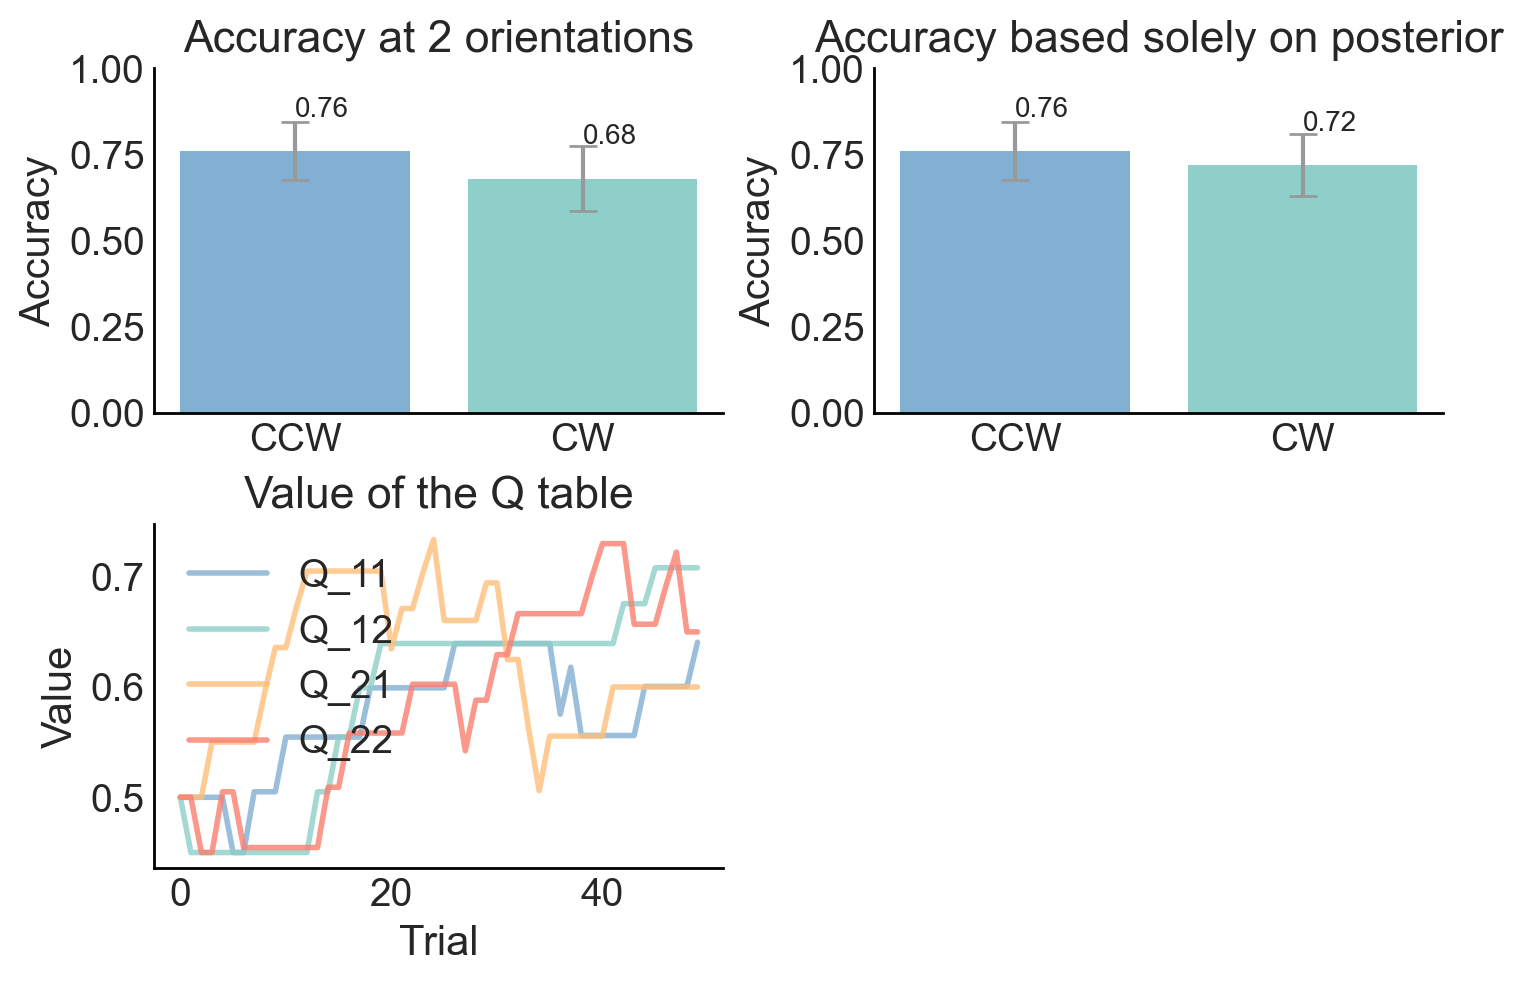

In [16]:
# visualize the performance
plt.subplot(2,2,1)
perform_at_0 = Sim_Data[Sim_Data['label'] == 0]['feedback']
perform_at_1 = Sim_Data[Sim_Data['label'] == 1]['feedback']
plt.bar(0, np.mean(perform_at_0), color=bl, label='CCW')
plt.errorbar(0, np.mean(perform_at_0), yerr=np.std(perform_at_0)/np.sqrt(len(perform_at_0)), color = ak, capsize=5)
plt.text(0, np.mean(perform_at_0)+0.1, str(np.round(np.mean(perform_at_0), 2)))
plt.bar(1, np.mean(perform_at_1), color=gr, label='CW')
plt.errorbar(1, np.mean(perform_at_1), yerr=np.std(perform_at_1)/np.sqrt(len(perform_at_1)), color = ak, capsize=5)
plt.text(1, np.mean(perform_at_1)+0.1, str(np.round(np.mean(perform_at_1), 2)))
plt.xticks([0, 1], ['CCW', 'CW'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Accuracy at 2 orientations')

# if decision is made solely based on posterior probability:
plt.subplot(2,2,2)
ori_higher_likelihood = Sim_Data['posterior CW'] > Sim_Data['posterior CCW']
ori_higher_likelihood.replace({True: 1, False: 0})
percept_at_0 = (ori_higher_likelihood[Sim_Data['label'] == 0] == 0)
percept_at_1 = (ori_higher_likelihood[Sim_Data['label'] == 1] == 1)
plt.bar(0, np.mean(percept_at_0), color=bl, label='CCW')
plt.errorbar(0, np.mean(percept_at_0), yerr=np.std(percept_at_0)/np.sqrt(len(percept_at_0)), color = ak, capsize=5)
plt.text(0, np.mean(percept_at_0)+0.1, str(np.round(np.mean(percept_at_0), 2)))
plt.bar(1, np.mean(percept_at_1), color=gr, label='CW')
plt.errorbar(1, np.mean(percept_at_1), yerr=np.std(percept_at_1)/np.sqrt(len(percept_at_1)), color = ak, capsize=5)
plt.text(1, np.mean(percept_at_1)+0.1, str(np.round(np.mean(percept_at_1), 2)))
plt.xticks([0, 1], ['CCW', 'CW'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Accuracy based solely on posterior')

# visualize the Q table
plt.subplot(2,2,3)
plt.plot(Sim_Data['Q_11'], color=bl, label='Q_11', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_12'], color=gr, label='Q_12', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_21'], color=ye, label='Q_21', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_22'], color=re, label='Q_22', alpha=0.8, linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Value of the Q table')
plt.legend()

plt.show()


In [17]:
# run 30 subjects, each with 20 blocks, each block has 50 trials

##### Params Setting ########
maxsubj = 30
maxblock = 20
trial_num = 50
learning_rate = 0.1
Q_init = np.array([[0.5, 0.5], [0.5, 0.5]])

##### Data Simulation #######
all_subj_data = pd.DataFrame(columns=['subj', 'block', 'trial', 
                                      'stimulus', 'label', 'posterior CCW', 'posterior CW', 
                                      'action', 'resp_ori', 'feedback', 'v_L', 'v_R', 'mapping'])

for iS in range(1, maxsubj + 1):
    for iB in range(1, maxblock + 1):
        data_samples, data_labels, posterior = Data_Gen(trial_num)
        mapping = np.random.choice([1, 2], trial_num)
        for iT in range(trial_num):
            posterior_i = posterior[:, iT]
            subj_state_i = mapping[iT]
            label_i = data_labels[iT]
            data_samples_i = data_samples[iT]
            if iT == 0:
                Q_i = Q_init
            else:
                Q_i = Q
            action_i, resp_ori_i, feedback_i, Q = RL_2_per_trial(posterior_i, subj_state_i, Q_i.copy(), label_i, learning_rate)
            temp_data = pd.DataFrame({'subj': iS, 'block': iB, 'trial': iT + 1, 'stimulus': data_samples_i, 'label': label_i, 
                                      'posterior CCW': posterior_i[0], 'posterior CW': posterior_i[1], 
                                      'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i,
                                      'v_L': Q_i[subj_state_i - 1, 0], 'v_R': Q_i[subj_state_i - 1, 1], 'mapping': subj_state_i}, index=[iT])
            all_subj_data = pd.concat([all_subj_data, temp_data], axis=0)

In [19]:
# Reorganize the data for Serial Dependence analysis
trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
all_data = {}

maxsubj = 30; maxblock = 20;
for iS in range(1, maxsubj + 1):
    subject_data = []
    raw_subj = all_subj_data[all_subj_data['subj'] == iS]
    for iB in range(1, maxblock + 1):
        block_data = raw_subj[raw_subj['block'] == iB]
        temp_data = trial_template.copy()
        temp_data['StimSeq'] = block_data['label'].values.copy()
        temp_data['StimSeq'].replace({0: -45, 1: 45}, inplace=True)
        temp_data['RespOri'] = block_data['resp_ori'].values.copy()
        temp_data['RespOri'].replace({0: -45, 1: 45}, inplace=True)
        temp_data['RespLorR'] = block_data['action'].values.copy()
        temp_data['Accuracy'] = block_data['feedback'].values.copy()
        temp_data['ProbeOriLeft'] = block_data['mapping'].values.copy()
        temp_data['ProbeOriLeft'].replace({1: -45, 2: 45}, inplace=True)
        temp_data['ProbeOriRight'] = block_data['mapping'].values.copy()
        temp_data['ProbeOriRight'].replace({1: 45, 2: -45}, inplace=True)
        temp_data['Qualified'] = True
        subject_data.append(temp_data)
    all_data[iS] = subject_data
    
def criterion(hit, FA):
    return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))

def dprime(hit, FA):
    return (stats.norm.ppf(hit) - stats.norm.ppf(FA))/np.sqrt(2)

def hit_fa(df):
    hit = df[(df['StimSeq'] == 45)]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == -45)]['Accuracy']
    return hit, fa

def hit_fa_motor(df):
    hit = df[(df['StimSeq'] == df['ProbeOriRight'])]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == df['ProbeOriLeft'])]['Accuracy']
    return hit, fa

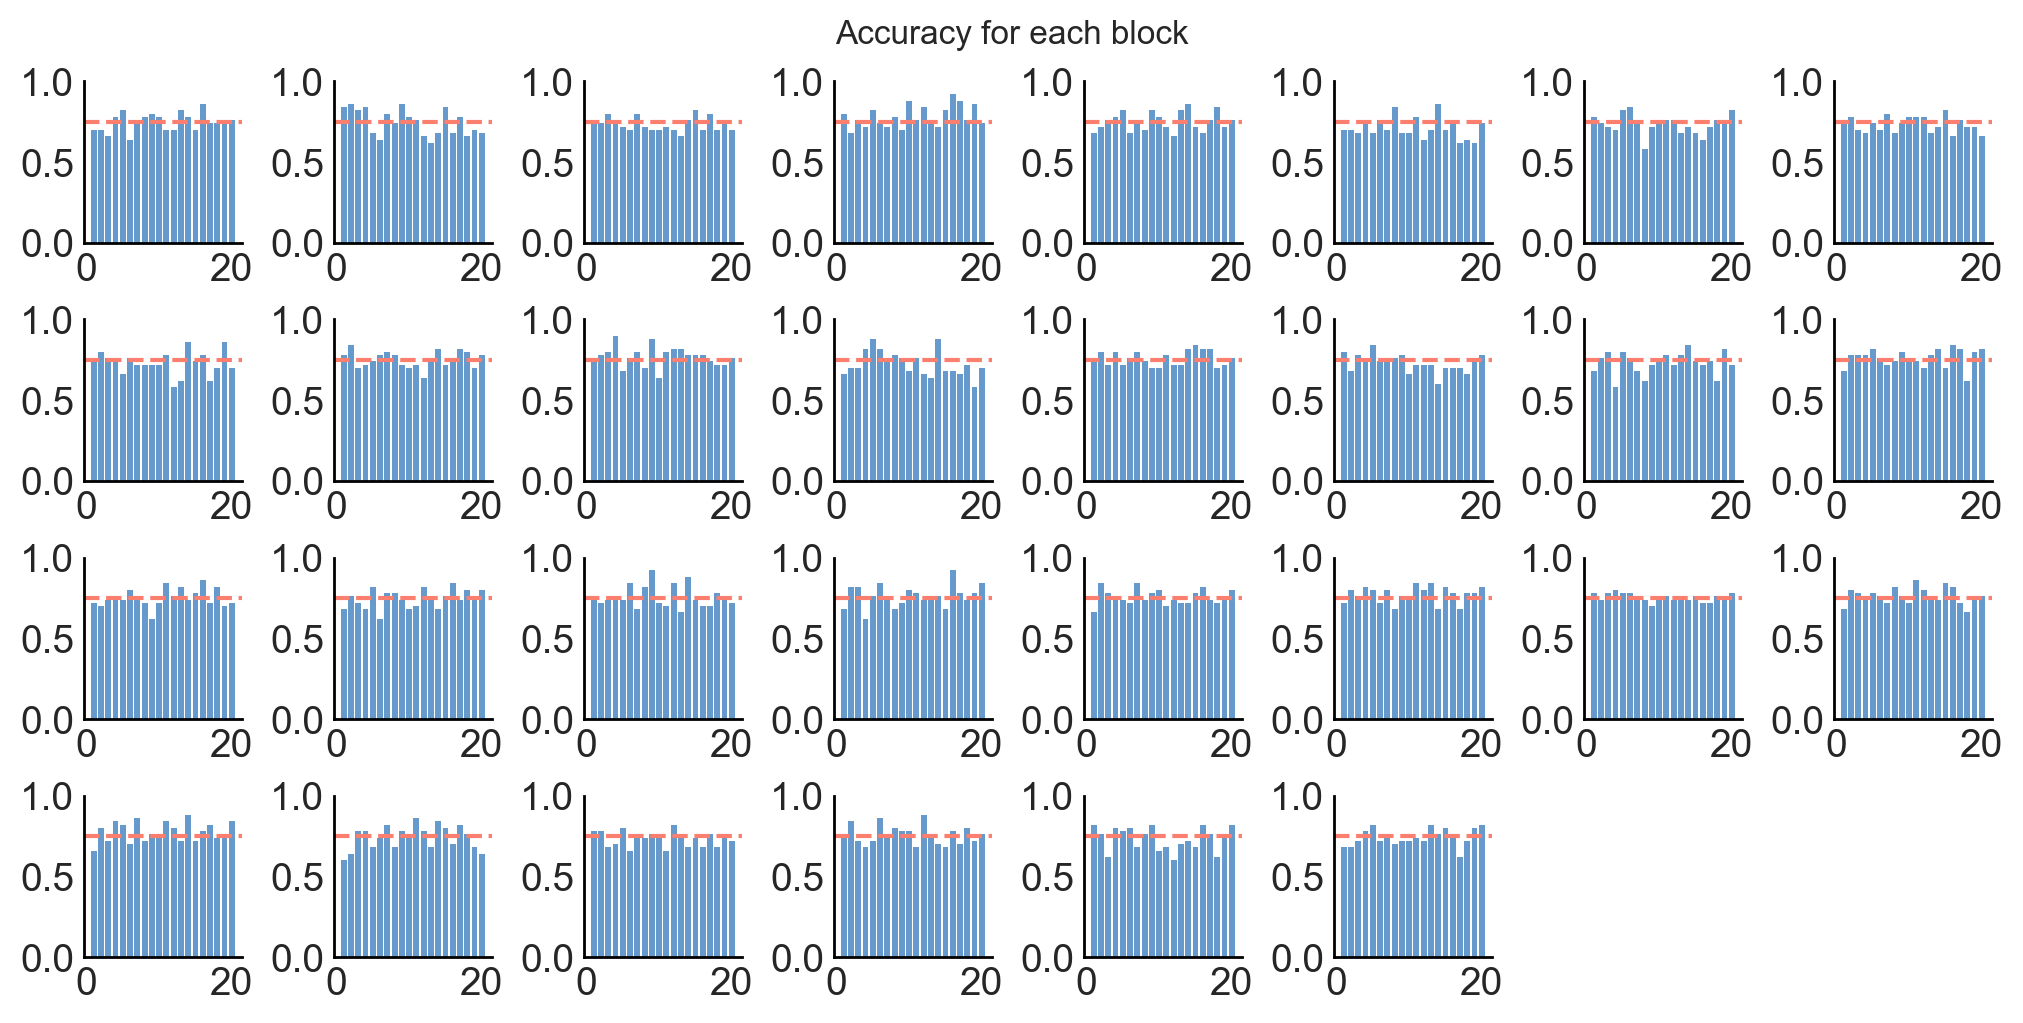

In [20]:
maxsubj = 30; maxblock = 20; maxtrial = 50

fig = plt.figure(figsize=(10, 5))

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # all blocks for this subject
    temp_accuracy = {f"{i}_block": {} for i in range(1, maxblock + 1)}
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]  # read current block
        temp_accuracy[key] = np.mean(block_data['Accuracy'])
    plt.subplot(4, 8, iS)
    plt.bar([int(i.split('_')[0]) for i in temp_accuracy.keys()], temp_accuracy.values(), color=grb)
    plt.ylim([0, 1])
    plt.axhline(y=0.75, color=re, linestyle='--')
    
fig.suptitle('Accuracy for each block')
plt.show()

In [21]:
def process_data_percept_cb(data, back):
    """Return hits and false alarms for a specific n-back"""
    hit, fa = hit_fa(data[(data['RespOri'].shift(back) == 45) & (data['Qualified'] == True)])
    hit_n, fa_n = hit_fa(data[(data['RespOri'].shift(back) == -45) & (data['Qualified'] == True)])
    return (hit, fa, hit_n, fa_n)

def calculate_sd_nback_percept_cb(all_data):
    maxsubj = 30; maxblock = 20; maxtrial = 50; num_backs = 10
    SD_nback_Percept_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_percept_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_n"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_n"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits = np.concatenate(temp_data[key]["Hit"])
            fas = np.concatenate(temp_data[key]["FA"])
            hits_n = np.concatenate(temp_data[key]["Hit_n"])
            fas_n = np.concatenate(temp_data[key]["FA_n"])
            cs = criterion(np.mean(hits_n), np.mean(fas_n)) - criterion(np.mean(hits), np.mean(fas))
            SD_nback_Percept_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Percept_cb)


def process_data_motor_cb(data, back):
    """Return hits and false alarms for motor responses"""
    hit_L, fa_L = hit_fa_motor(data[(data['RespLorR'].shift(back) == -1) & (data['Qualified'] == True)])
    hit_R, fa_R = hit_fa_motor(data[(data['RespLorR'].shift(back) == 1) & (data['Qualified'] == True)])
    return (hit_L, fa_L, hit_R, fa_R)

def calculate_sd_nback_motor_cb(all_data):
    maxsubj = 30; maxblock = 20; num_backs = 10
    SD_nback_Motor_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_motor_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit_L"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA_L"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_R"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_R"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits_L = np.concatenate(temp_data[key]["Hit_L"])
            fas_L = np.concatenate(temp_data[key]["FA_L"])
            hits_R = np.concatenate(temp_data[key]["Hit_R"])
            fas_R = np.concatenate(temp_data[key]["FA_R"])
            cs = criterion(np.mean(hits_L), np.mean(fas_L)) - criterion(np.mean(hits_R), np.mean(fas_R))
            SD_nback_Motor_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Motor_cb)

SD_nbacks_Percept = calculate_sd_nback_percept_cb(all_data)
SD_nbacks_Motor = calculate_sd_nback_motor_cb(all_data)

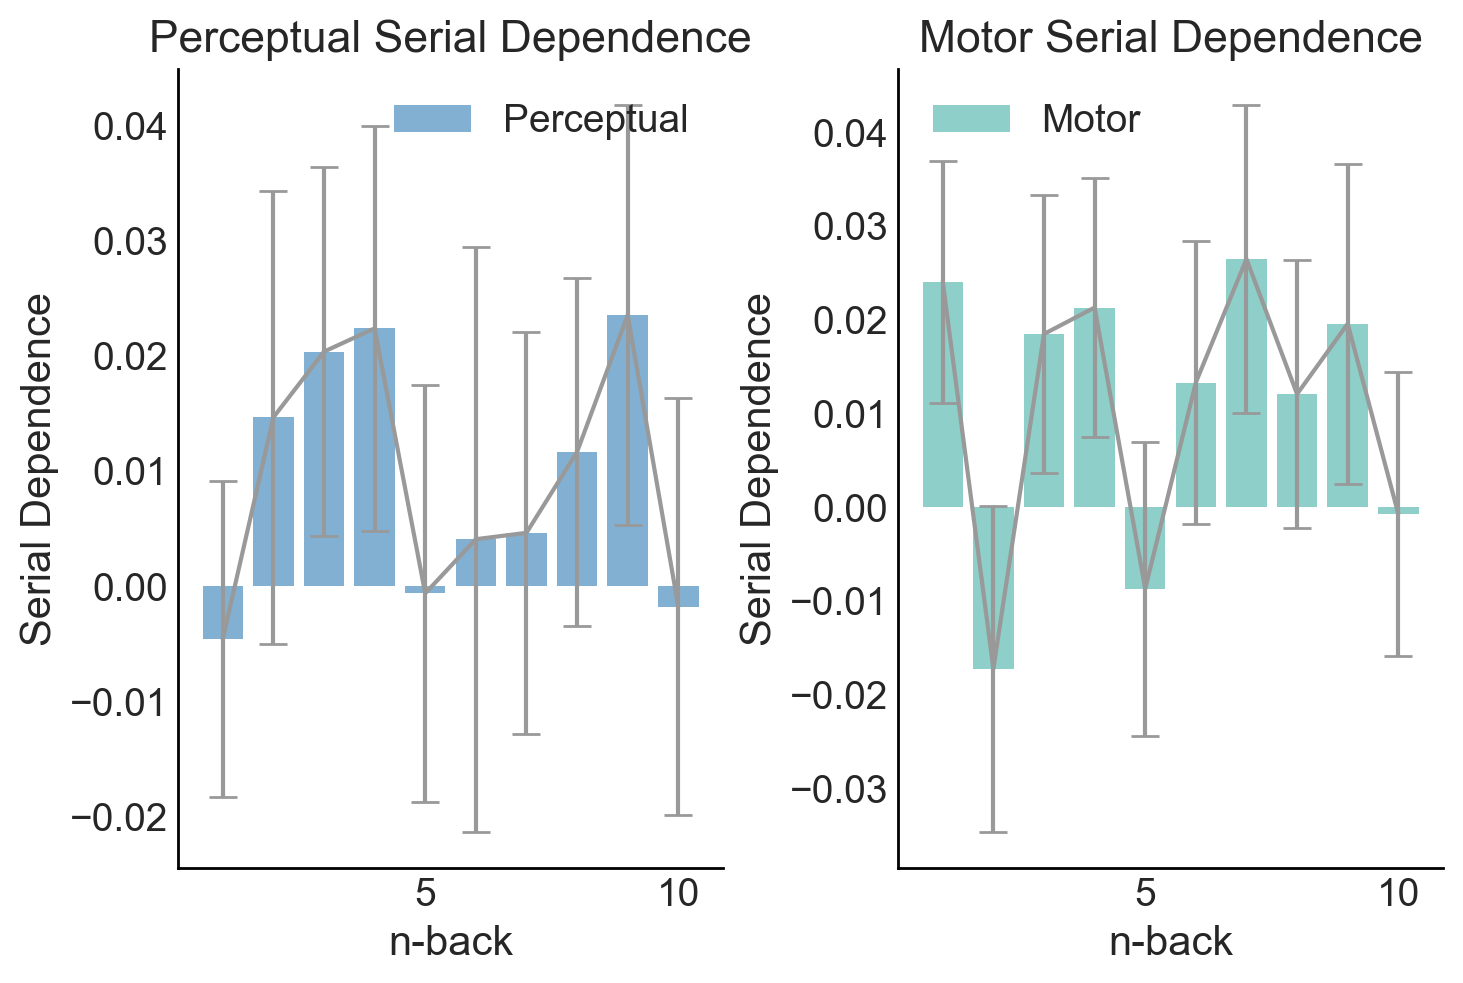

In [28]:
plt.subplot(1,2,1)
plt.bar(np.arange(1, 11), SD_nbacks_Percept.mean(axis=0), color=bl, label='Perceptual')
plt.errorbar(np.arange(1, 11), SD_nbacks_Percept.mean(axis=0), yerr=SD_nbacks_Percept.std(axis=0)/np.sqrt(maxsubj), color = ak, capsize=5)
plt.xlabel('n-back')
plt.ylabel('Serial Dependence')
plt.title('Perceptual Serial Dependence')
plt.legend()
plt.subplot(1,2,2)
plt.bar(np.arange(1, 11), SD_nbacks_Motor.mean(axis=0), color=gr, label='Motor')
plt.errorbar(np.arange(1, 11), SD_nbacks_Motor.mean(axis=0), yerr=SD_nbacks_Motor.std(axis=0)/np.sqrt(maxsubj), color = ak, capsize=5)
plt.xlabel('n-back')
plt.ylabel('Serial Dependence')
plt.title('Motor Serial Dependence')
plt.legend()
plt.show()

## 3 Model-based RL with 2 x 2 x 2 Q-table
In the previous section, we assume that the observer only has 2 possible state spaces. However, in the real world, the observer may have 4 possible state spaces, because the observer may not know the true orientation of the stimulus. Thus, we have 4 possible state spaces, and 2 possible action spaces. Thus, we have 4 x 2 = 8 possible Q-tables.

In this model, the state is jointly determined by the **stimulus** and the **response mapping**.

### Mathematical Formulation
**Q-table**: $Q_{i,j}$, where $i$ is the state space, and $j$ is the action space. a 4 x 2 Q-table is shown below:
|  | $a_1$ (L) | $a_2$ (R) |
| --- | --- | --- |
| $s_1$ [ \\ ] [ \ / ] | $Q_{1,1}$ | $Q_{1,2}$ |
| $s_2$ [ \\ ] [ / \\ ] | $Q_{2,1}$ | $Q_{2,2}$ |
| $s_3$ [ / ] [ \ / ] | $Q_{3,1}$ | $Q_{3,2}$ |
| $s_4$ [ / ] [ / \\ ] | $Q_{4,1}$ | $Q_{4,2}$ |


In [35]:
# Simulate the Reinforcement Learning process per trial

def RL_3_per_trial(posterior, subj_state, Q, label, learning_rate, reward = 1, punishment = 0):
    '''
    Simulate the Reinforcement Learning model 2 process per trial.
    param posterior: the posterior probability of the signal : [\  /], this model is just likelihood
    param subj_state: the mapping of the response key (state_space):
        1 - [ \ ] [ \ / ]
        2 - [ \ ] [ / \ ]
        3 - [ / ] [ \ / ]
        4 - [ / ] [ / \ ]
    param Q: the Q table of the RL model, 2 by 2 matrix, [[s_1_v_L, s_1_v_R]; [s_2_v_L, s_2_v_R]; [s_3_v_L, s_3_v_R]; [s_4_v_L, s_4_v_R]]
    param label: the label of the stimulus: 1 for CW / and 0 for CCW \ 
    param learning_rate: the learning rate of the RL model
    param reward/punishment: the reward and punishment value for the correct response
    
    Return: 
    action: the action chosen by the model, -1 for left and 1 for right
    resp_ori: the orientation of the response, 1 for CW / and 0 for CCW \ 
    feedback: the feedback given by the environment, 1 for correct and 0 for incorrect
    Q: the updated Q table
    '''
    key_mapping = {-1: [0, 1, 0, 1], 1: [1, 0, 1, 0]}
    
    if subj_state in [1, 3]:
        posterior_arrange = posterior
    else:
        posterior_arrange = posterior[::-1]
        
    # choose the action with the larger utility and receive the feedback
    U_L = posterior_arrange[0] * Q[subj_state - 1, 0]
    U_R = posterior_arrange[1] * Q[subj_state - 1, 1]
    action = np.sign(U_R - U_L)
    resp_ori = key_mapping[action][subj_state - 1]
    feedback = int(resp_ori == label)
    
    # update the value of the chosen action
    if action == -1:
        Q[subj_state - 1, 0] = (1 - learning_rate) * Q[subj_state - 1, 0] + learning_rate * feedback
    else:
        Q[subj_state - 1, 1] = (1 - learning_rate) * Q[subj_state - 1, 1] + learning_rate * feedback
        
    return action, resp_ori, feedback, Q

# Simulate the Reinforcement Learning process for a given number of trials
# Demonstration Data
trial_num = 50
learning_rate = 0.1
Q_init = np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])

data_samples, data_labels, posterior = Data_Gen(trial_num)
mapping = np.random.choice([1, 2, 3, 4], trial_num)

Sim_Data = pd.DataFrame(columns=['trial', 'stimulus', 'label', 'posterior CCW', 'posterior CW', 'action', 'resp_ori',
                                    'feedback', 'Q_11', 'Q_12', 'Q_21', 'Q_22', 'Q_31', 'Q_32', 'Q_41', 'Q_42', 'subj_state'])

for iT in range(trial_num):
    posterior_i = posterior[:, iT]
    subj_state_i = mapping[iT]
    label_i = data_labels[iT]
    data_samples_i = data_samples[iT]
    if iT == 0:
        Q_i = Q_init
    else:
        Q_i = Q
    action_i, resp_ori_i, feedback_i, Q = RL_3_per_trial(posterior_i, subj_state_i, Q_i.copy(), label_i, learning_rate)
    temp_data = pd.DataFrame({'trial': iT + 1, 'stimulus': data_samples_i, 'label': label_i, 'posterior CCW': posterior_i[0],
                                'posterior CW': posterior_i[1], 'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i,
                                'Q_11': Q_i[0, 0], 'Q_12': Q_i[0, 1], 'Q_21': Q_i[1, 0], 'Q_22': Q_i[1, 1], 
                                'Q_31': Q_i[2, 0], 'Q_32': Q_i[2, 1], 'Q_41': Q_i[3, 0], 'Q_42': Q_i[3, 1], 'subj_state': subj_state_i}, index=[iT])
    Sim_Data = pd.concat([Sim_Data, temp_data], axis=0)
    
Sim_Data.head()
    
    

,trial,stimulus,label,posterior CCW,posterior CW,action,resp_ori,feedback,Q_11,Q_12,Q_21,Q_22,Q_31,Q_32,Q_41,Q_42,subj_state
0,1,-1.151027,0.0,0.987033,0.012967,1.0,0,1,0.50,0.5,0.50,0.50,0.5,0.5,0.50,0.5,2
1,2,-0.273328,0.0,0.851573,0.148427,-1.0,0,1,0.50,0.5,0.50,0.55,0.5,0.5,0.50,0.5,1
2,3,3.269067,1.0,0.000094,0.999906,-1.0,1,1,0.55,0.5,0.50,0.55,0.5,0.5,0.50,0.5,2
3,4,2.647583,1.0,0.001883,0.998117,-1.0,1,1,0.55,0.5,0.55,0.55,0.5,0.5,0.50,0.5,4
4,5,0.654232,0.0,0.417593,0.582407,-1.0,1,0,0.55,0.5,0.55,0.55,0.5,0.5,0.55,0.5,2


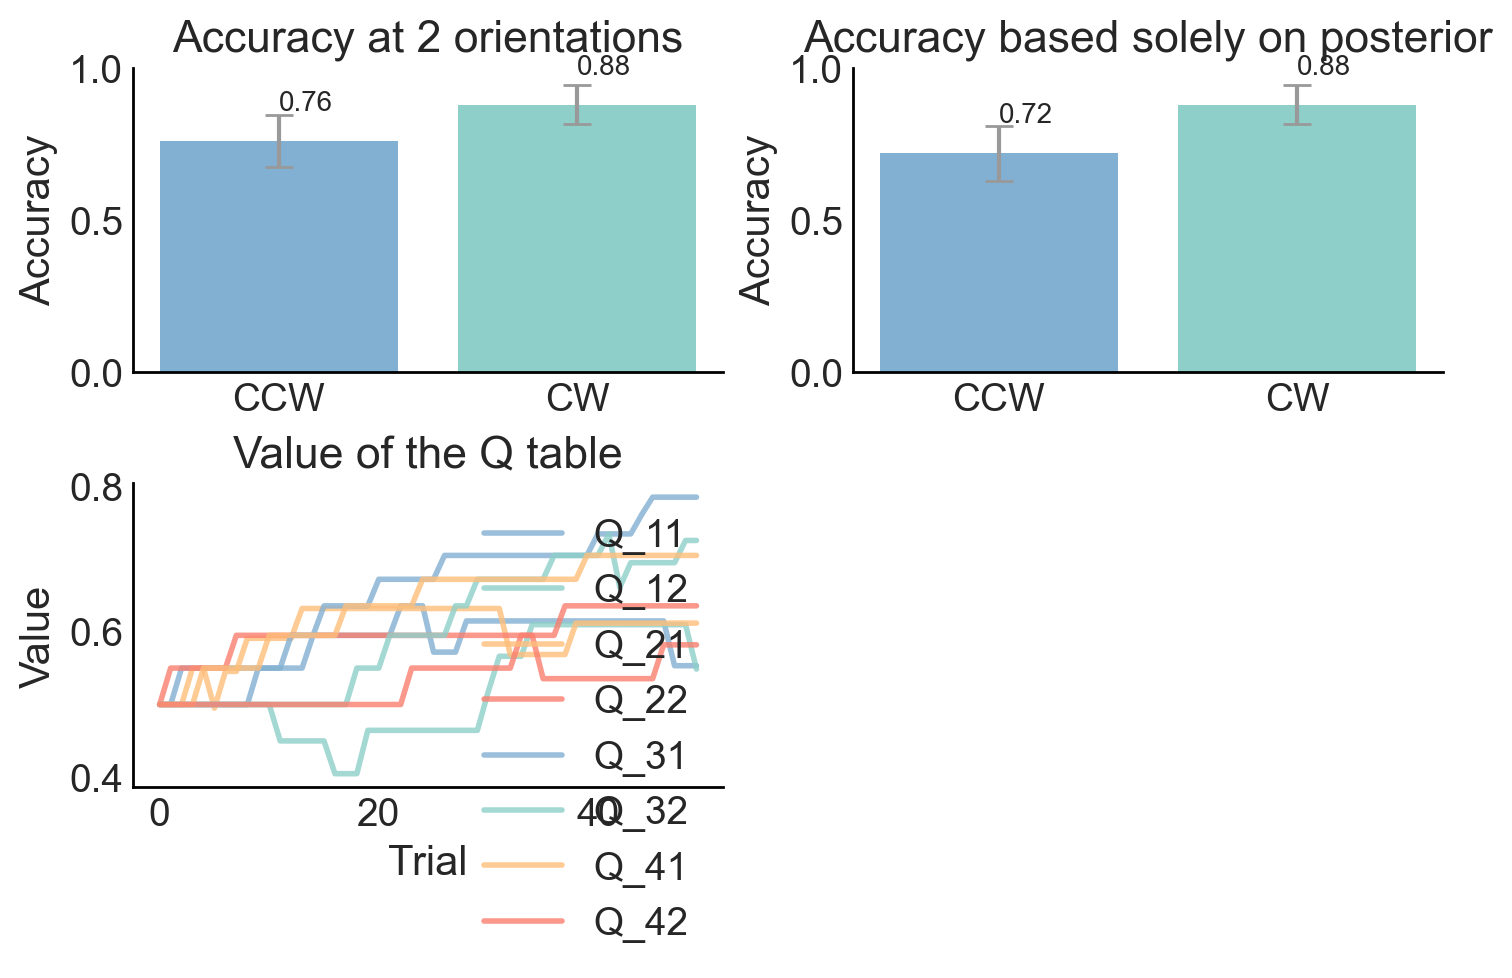

In [36]:
# visualize the performance
plt.subplot(2,2,1)
perform_at_0 = Sim_Data[Sim_Data['label'] == 0]['feedback']
perform_at_1 = Sim_Data[Sim_Data['label'] == 1]['feedback']
plt.bar(0, np.mean(perform_at_0), color=bl, label='CCW')
plt.errorbar(0, np.mean(perform_at_0), yerr=np.std(perform_at_0)/np.sqrt(len(perform_at_0)), color = ak, capsize=5)
plt.text(0, np.mean(perform_at_0)+0.1, str(np.round(np.mean(perform_at_0), 2)))
plt.bar(1, np.mean(perform_at_1), color=gr, label='CW')
plt.errorbar(1, np.mean(perform_at_1), yerr=np.std(perform_at_1)/np.sqrt(len(perform_at_1)), color = ak, capsize=5)
plt.text(1, np.mean(perform_at_1)+0.1, str(np.round(np.mean(perform_at_1), 2)))
plt.xticks([0, 1], ['CCW', 'CW'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Accuracy at 2 orientations')

# if decision is made solely based on posterior probability:
plt.subplot(2,2,2)
ori_higher_likelihood = Sim_Data['posterior CW'] > Sim_Data['posterior CCW']
ori_higher_likelihood.replace({True: 1, False: 0})
percept_at_0 = (ori_higher_likelihood[Sim_Data['label'] == 0] == 0)
percept_at_1 = (ori_higher_likelihood[Sim_Data['label'] == 1] == 1)
plt.bar(0, np.mean(percept_at_0), color=bl, label='CCW')
plt.errorbar(0, np.mean(percept_at_0), yerr=np.std(percept_at_0)/np.sqrt(len(percept_at_0)), color = ak, capsize=5)
plt.text(0, np.mean(percept_at_0)+0.1, str(np.round(np.mean(percept_at_0), 2)))
plt.bar(1, np.mean(percept_at_1), color=gr, label='CW')
plt.errorbar(1, np.mean(percept_at_1), yerr=np.std(percept_at_1)/np.sqrt(len(percept_at_1)), color = ak, capsize=5)
plt.text(1, np.mean(percept_at_1)+0.1, str(np.round(np.mean(percept_at_1), 2)))
plt.xticks([0, 1], ['CCW', 'CW'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Accuracy based solely on posterior')

# visualize the Q table
plt.subplot(2,2,3)
plt.plot(Sim_Data['Q_11'], color=bl, label='Q_11', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_12'], color=gr, label='Q_12', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_21'], color=ye, label='Q_21', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_22'], color=re, label='Q_22', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_31'], color=bl, label='Q_31', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_32'], color=gr, label='Q_32', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_41'], color=ye, label='Q_41', alpha=0.8, linewidth=2)
plt.plot(Sim_Data['Q_42'], color=re, label='Q_42', alpha=0.8, linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Value of the Q table')
plt.legend()

plt.show()
